# 0.0. IMPORTS

In [1]:
# Manipulacao
import pandas as pd
import numpy as np
import re
import statistics

# Visualizacao
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display       import Image

## 0.1. Funcoes Auxiliares

In [245]:
def jupyter_settings():
    %matplotlib inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    sns.set()
    
def cont_columns(first_value, df):
    cont = 0
    for value in df.columns:
        if value.split('-')[0] == first_value:
            cont += 1
    print(f'Número de colunas {first_value}-#:{cont}')

In [246]:
jupyter_settings()

## 0.2. Dados

In [247]:
df_exp = pd.read_csv('https://github.com/tadeucbm/imersao-dados-desafio-final/blob/main/Dados/dados_experimentos.zip?raw=true', compression = 'zip')
df_result = pd.read_csv('https://github.com/tadeucbm/imersao-dados-desafio-final/blob/main/Dados/dados_resultados.csv?raw=true')

In [248]:
df_exp.head()

,id,tratamento,tempo,dose,droga,g-0,g-1,g-2,g-3,g-4,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,com_droga,24,D1,b68db1d53,1.0620,0.5577,-0.2479,-0.6208,-0.1944,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,com_droga,72,D1,df89a8e5a,0.0743,0.4087,0.2991,0.0604,1.0190,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,com_droga,48,D1,18bb41b2c,0.6280,0.5817,1.5540,-0.0764,-0.0323,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,id_0015fd391,com_droga,48,D1,8c7f86626,-0.5138,-0.2491,-0.2656,0.5288,4.0620,...,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,id_001626bd3,com_droga,72,D2,7cbed3131,-0.3254,-0.4009,0.9700,0.6919,1.4180,...,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125


In [249]:
df_result

,id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,id_0015fd391,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,id_001626bd3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23809,id_fffb1ceed,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23810,id_fffb70c0c,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23811,id_fffc1c3f4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23812,id_fffcb9e7c,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# 1.0. DESCRICAO DOS DADOS

O objetivo da descrição dos dados é obter uma visão geral do dados que estamos trabalhando. Nesse estágio inicial iremos seguir as seguintes etapas:
- **Dimensão dos Dados:** Encontrar a quantidade de linhas e colunas;
- **Tipo dos Dados:** Cada coluna possui um tipo específico(Booleano, String, Int ou Float). Para uma melhor análise e resolução de possíveis divergências, essa informação é importante;
- **Valores Faltantes:** Na vida real nem sempre teremos dados livres de incoerências. Os valores faltantes são aqueles que por algum motivo não foram colocados. É importante analisar o contexto para tratar esse dados;
- **Descrição das Colunas**: Descobrir os valores únicos;
- **Descrição Estatística:** Uma descrição básica dos dados. O objetivo é entender de maneira ampla o funcionamento das variáveis;
- **Entendimento:** Qual o significado dos dados?

## 1.1. Dimensão dos Dados

### 1.1.1. df_exp

In [250]:
print(f'Número de linhas:{df_exp.shape[0]}')
print(f'Número de colunas:{df_exp.shape[1]}')

Número de linhas:23814
Número de colunas:877


In [251]:
# Contando o número de valores 'g-#'
cont_columns('g', df_exp)

# Contando o número de valores 'c-#'
cont_columns('c', df_exp)

Número de colunas g-#:772
Número de colunas c-#:100


### 1.1.2. df_result

In [252]:
print(f'Número de linhas:{df_result.shape[0]}')
print(f'Número de colunas:{df_result.shape[1]}')

Número de linhas:23814
Número de colunas:207


## 1.2. Tipo dos Dados

### 1.2.1. df_exp

In [253]:
df_exp.dtypes[[0, 1, 2, 3, 4, 5, 777]]

id             object
tratamento     object
tempo           int64
dose           object
droga          object
g-0           float64
c-0           float64
dtype: object

### 1.2.2. df_result

In [254]:
df_result.dtypes

id                                       object
5-alpha_reductase_inhibitor               int64
11-beta-hsd1_inhibitor                    int64
acat_inhibitor                            int64
acetylcholine_receptor_agonist            int64
                                          ...  
ubiquitin_specific_protease_inhibitor     int64
vegfr_inhibitor                           int64
vitamin_b                                 int64
vitamin_d_receptor_agonist                int64
wnt_inhibitor                             int64
Length: 207, dtype: object

## 1.3. Valores Faltantes

### 1.3.1. df_exp

In [255]:
df_exp.isna().sum().sort_values(ascending=True)

id       0
g-572    0
g-573    0
g-574    0
g-575    0
        ..
g-291    0
g-292    0
g-293    0
g-282    0
c-99     0
Length: 877, dtype: int64

### 1.3.2. df_result

In [256]:
df_result.isna().sum().sort_values(ascending=True)

id                                      0
monoacylglycerol_lipase_inhibitor       0
monoamine_oxidase_inhibitor             0
monopolar_spindle_1_kinase_inhibitor    0
mtor_inhibitor                          0
                                       ..
cyclooxygenase_inhibitor                0
cytochrome_p450_inhibitor               0
dihydrofolate_reductase_inhibitor       0
cdk_inhibitor                           0
wnt_inhibitor                           0
Length: 207, dtype: int64

## 1.4. Descrição das Colunas

### 1.4.1. df_exp

#### 1.4.1.1 Valores Únicos

In [257]:
for col in df_exp.columns:
    if len(df_exp[col].unique()) < 10:
        print(f'{col}: {df_exp[col].unique()}')

tratamento: ['com_droga' 'com_controle']
tempo: [24 72 48]
dose: ['D1' 'D2']


As demais colunas são valores continuos ou identificadores.

#### 1.4.1.2. Proporções

In [258]:
for col in df_exp.columns:
    if len(df_exp[col].unique()) < 10:
        print(col)
        print(f'{df_exp[col].value_counts(normalize=True)}')
        print()

tratamento
com_droga       0.921643
com_controle    0.078357
Name: tratamento, dtype: float64

tempo
48    0.346435
72    0.327202
24    0.326363
Name: tempo, dtype: float64

dose
D1    0.510078
D2    0.489922
Name: dose, dtype: float64



### 1.4.2. df_result

Na tabela de resultados, os valores são binários. Eles podem ser classificados em 1 (reage) ou 0 (não reage)

## 1.5. Descrição Estatística

### 1.5.1. Variáveis Contínuas

In [259]:
# Separando as variáveis contínuas
var_cont = df_exp.iloc[:, 5:]

In [260]:
# Central Tendency - mean, meadina 
ct1 = pd.DataFrame(var_cont.apply(np.mean)).T
ct2 = pd.DataFrame(var_cont.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(var_cont.apply(np.std)).T 
d2 = pd.DataFrame(var_cont.apply(min)).T 
d3 = pd.DataFrame(var_cont.apply(max)).T 
d4 = pd.DataFrame(var_cont.apply(lambda x: x.max() - x.min())).T 
d5 = pd.DataFrame(var_cont.apply(lambda x: x.skew())).T 
d6 = pd.DataFrame(var_cont.apply(lambda x: x.kurtosis())).T 

# Concat
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,g-0,-5.513,10.000,15.513,0.248366,-0.00885,1.393369,2.790270,11.332955
1,g-1,-5.737,5.039,10.776,-0.095684,-0.04660,0.812346,-0.169398,2.305161
2,g-2,-9.104,8.257,17.361,0.152253,0.07520,1.035710,0.361242,3.893016
3,g-3,-5.998,10.000,15.998,0.081971,0.00805,0.949992,1.816132,10.988063
4,g-4,-6.369,10.000,16.369,0.057347,-0.02690,1.032070,1.092531,6.895809
...,...,...,...,...,...,...,...,...,...
867,c-95,-10.000,2.814,12.814,-0.353726,-0.01025,1.629256,-3.423862,14.322822
868,c-96,-10.000,3.505,13.505,-0.463485,-0.00125,2.059682,-3.289216,11.498551
869,c-97,-10.000,2.924,12.924,-0.378241,-0.00680,1.703579,-3.310345,12.822259
870,c-98,-10.000,3.111,13.111,-0.470252,0.01400,1.834789,-2.981826,10.141278


### 1.5.2 Variáveis categóricas

In [261]:
# separação das variáveis
df_aux_1 = df_exp.iloc[:, 1:4]
df_aux_2 = df_result.iloc[:, 1:]

# concatenando as variáveis
df_aux_3 = pd.concat([df_aux_1, df_aux_2], axis=1)

# transformando as variáveis int em object
for col in df_aux_3:
    if df_aux_3[col].dtypes != 'object':
        df_aux_3[col] = df_aux_3[col].astype('str')

In [262]:
moda = pd.DataFrame(df_aux_3.apply(lambda x: statistics.mode(x))) # DataFrame com os valores das modas
moda.columns = list_columns # renomear colunas

moda

,moda
tratamento,com_droga
tempo,48
dose,D1
5-alpha_reductase_inhibitor,0
11-beta-hsd1_inhibitor,0
...,...
ubiquitin_specific_protease_inhibitor,0
vegfr_inhibitor,0
vitamin_b,0
vitamin_d_receptor_agonist,0


In [263]:
df_result.columns

Index(['id', '5-alpha_reductase_inhibitor', '11-beta-hsd1_inhibitor',
       'acat_inhibitor', 'acetylcholine_receptor_agonist',
       'acetylcholine_receptor_antagonist', 'acetylcholinesterase_inhibitor',
       'adenosine_receptor_agonist', 'adenosine_receptor_antagonist',
       'adenylyl_cyclase_activator',
       ...
       'tropomyosin_receptor_kinase_inhibitor', 'trpv_agonist',
       'trpv_antagonist', 'tubulin_inhibitor', 'tyrosine_kinase_inhibitor',
       'ubiquitin_specific_protease_inhibitor', 'vegfr_inhibitor', 'vitamin_b',
       'vitamin_d_receptor_agonist', 'wnt_inhibitor'],
      dtype='object', length=207)

## 1.6. Entendimento

### experimento:
   **id:**
   Identificador do conjunto amostral. Identifica culturas de células; 
    
    
   **tratamento:**
   O tipo de tratamento utilizado. Pode ser:
   - com_droga: uso da droga;
   - com_controle: uso de controle.
   
   
   **tempo:**
   Tempo que o efeito da droga se prolonga. Pode ser:
   - 24: 24 horas
   - 48: 48 horas
   - 72: 72 horas
   
   
   **dose:**
   Tipo de dose utilizada.
   - D1: dose tipo 1
   - D2: dose tipo 2


   **droga:**
   Droga utilizada. São identificadores irreconhecíveis.


   **g-#:**
   Expressão dos genes. Os valores são normalizados
   - Normalizadoe ntre -10 e 10
    
    
   **c-#:**
   Viabilidade celular.
   - Normalizado entre -10 e 10

### resultado:

   **id**: Identificador do conjunto amostral. Identifica culturas de células;

   **Demais colunas**: Mecanismo de ação com o alvo.
   - 0: Não ativa o receptor
   - 1: Ativa o receptor

# 2.0. FEATURE ENGINEERING

## 2.1. Mapa Mental de Hipóteses

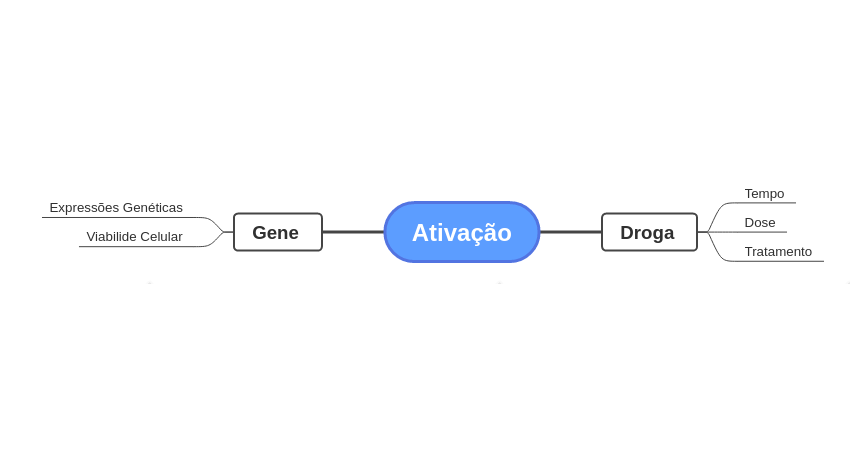

In [8]:
Image('https://raw.githubusercontent.com/tadeucbm/imersao-dados-desafio-final/main/img/MindMapHypothesis.png')

## 2.2. Criação das Hipóteses

### 2.2.1. Gene

**1.** Maior viabilidade celular implica em mais ativações

**2.** Uma maior quantidade de expressões genéticas implica em mais ativações

### 2.2.2. Droga

**1.** Tratamentos com controle não possuem ativações

**2.** D2 ativa mais que D1

**3.** Um maior período de efeito da droga implica em mais ativações

### 2.2.3. Geral

**1.** As ativações em genes com maior viabilidade celular aumentam de acordo com o tempo de efeito da droga

**2.** As ativaçõem em genes com valores de expressão genética mais elevados aumentam de acordo com o tempo de efeito da droga.

**3.** Análise temporal das ativações das Doses de acordo com o tempo de efeito da droga.

### 2.2.4. Lista Final

**1.** Maior viabilidade celular implica em mais ativações

**2.** Uma maior quantidade de expressões genéticas implica em mais ativações

**3.** Tratamentos com controle não possuem ativações

**4.** D2 ativa mais que D1

**5.** Um maior período de efeito da droga implica em mais ativações

**6.** As ativações em genes com maior viabilidade celular aumentam de acordo com o tempo de efeito da droga

**7.** As ativaçõem em genes com valores de expressão genética mais elevados aumentam de acordo com o tempo de efeito da droga.

**8.** Análise temporal das ativações das Doses de acordo com o tempo de efeito da droga.

## 2.3. Feature Engineering

In [268]:
# contagem de moa's por cultura de célula
df_result['n_moa'] = df_result.select_dtypes('int64').sum(axis=1)

# se o moa ativa ou não
df_result['ativo_moa'] = [0 if value == 0 else 1 for value in df_result['n_moa']]

In [270]:
# merge dos conjuntos de dados
df_2 = pd.merge(df_exp, df_result[['id', 'n_moa', 'ativo_moa']], on='id')

In [271]:
df_2

,id,tratamento,tempo,dose,droga,g-0,g-1,g-2,g-3,g-4,...,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99,n_moa,ativo_moa
0,id_000644bb2,com_droga,24,D1,b68db1d53,1.0620,0.5577,-0.2479,-0.6208,-0.1944,...,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176,3,1
1,id_000779bfc,com_droga,72,D1,df89a8e5a,0.0743,0.4087,0.2991,0.0604,1.0190,...,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371,0,0
2,id_000a6266a,com_droga,48,D1,18bb41b2c,0.6280,0.5817,1.5540,-0.0764,-0.0323,...,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931,7,1
3,id_0015fd391,com_droga,48,D1,8c7f86626,-0.5138,-0.2491,-0.2656,0.5288,4.0620,...,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154,0,0
4,id_001626bd3,com_droga,72,D2,7cbed3131,-0.3254,-0.4009,0.9700,0.6919,1.4180,...,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23809,id_fffb1ceed,com_droga,24,D2,df1d0a5a1,0.1394,-0.0636,-0.1112,-0.5080,-0.4713,...,-0.8121,0.3434,0.5372,-0.3246,0.0631,0.9171,0.5258,0.4680,3,1
23810,id_fffb70c0c,com_droga,24,D2,ecf3b6b74,-1.3260,0.3478,-0.3743,0.9905,-0.7178,...,0.0423,-0.3195,-0.8086,-0.9798,-0.2084,-0.1224,-0.2715,0.3689,3,1
23811,id_fffc1c3f4,com_controle,48,D2,cacb2b860,0.3942,0.3756,0.3109,-0.7389,0.5505,...,0.7343,0.2807,0.4116,0.6422,0.2256,0.7592,0.6656,0.3808,0,0
23812,id_fffcb9e7c,com_droga,24,D1,8b87a7a83,0.6660,0.2324,0.4392,0.2044,0.8531,...,-0.2012,0.1506,1.5230,0.7101,0.1732,0.7015,-0.6290,0.0740,3,1


# 3.0. ANALISE EXPLORATORIA DE DADOS

In [277]:
df_3 = df_2.copy()

## 3.1. Análise Univariada

### 3.1.1. MOA

Text(0.5, 1.0, '')

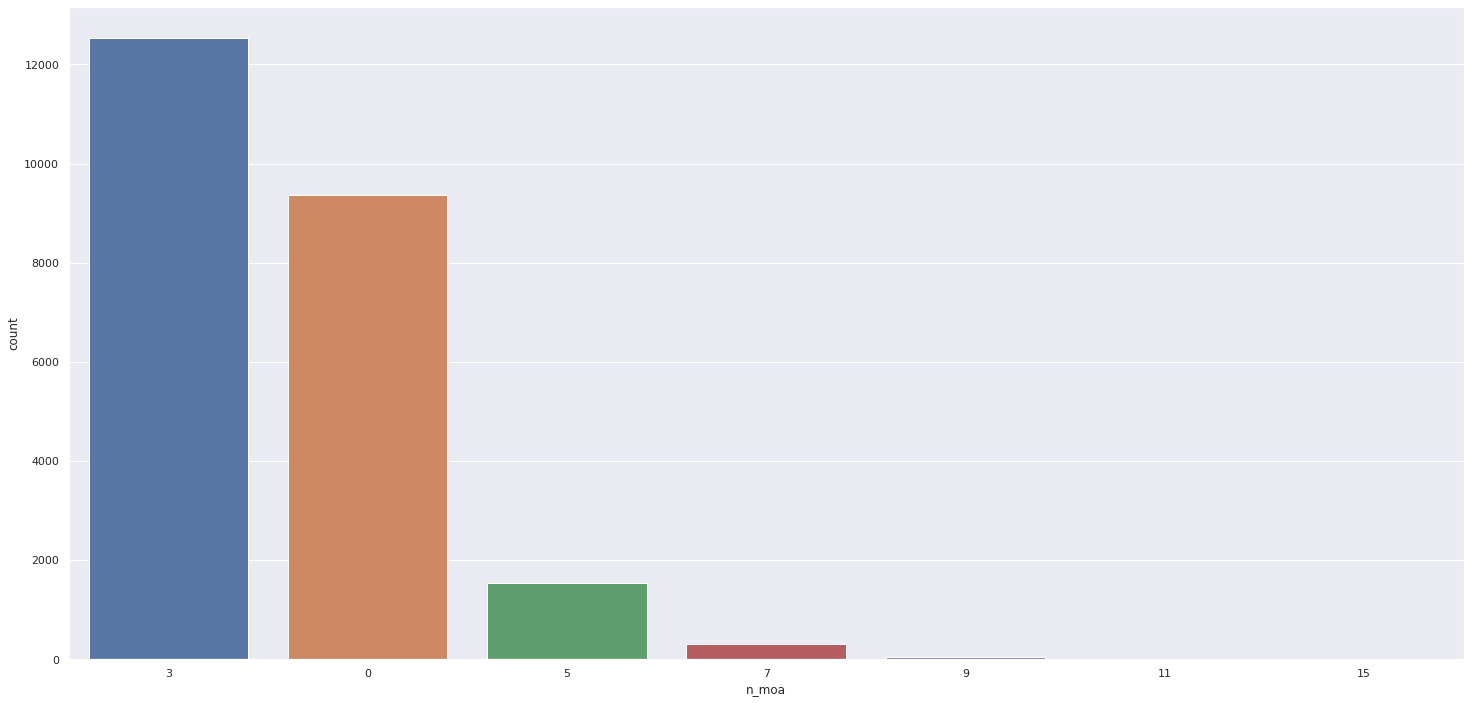

In [284]:
sns.countplot(x = df_3['n_moa'],
              order = df_3['n_moa'].value_counts().index)
plt.title('')

In [282]:
df_3['n_moa'].unique()

array([ 3,  0,  7,  5,  9, 11, 15])

<AxesSubplot:xlabel='ativo_moa', ylabel='count'>

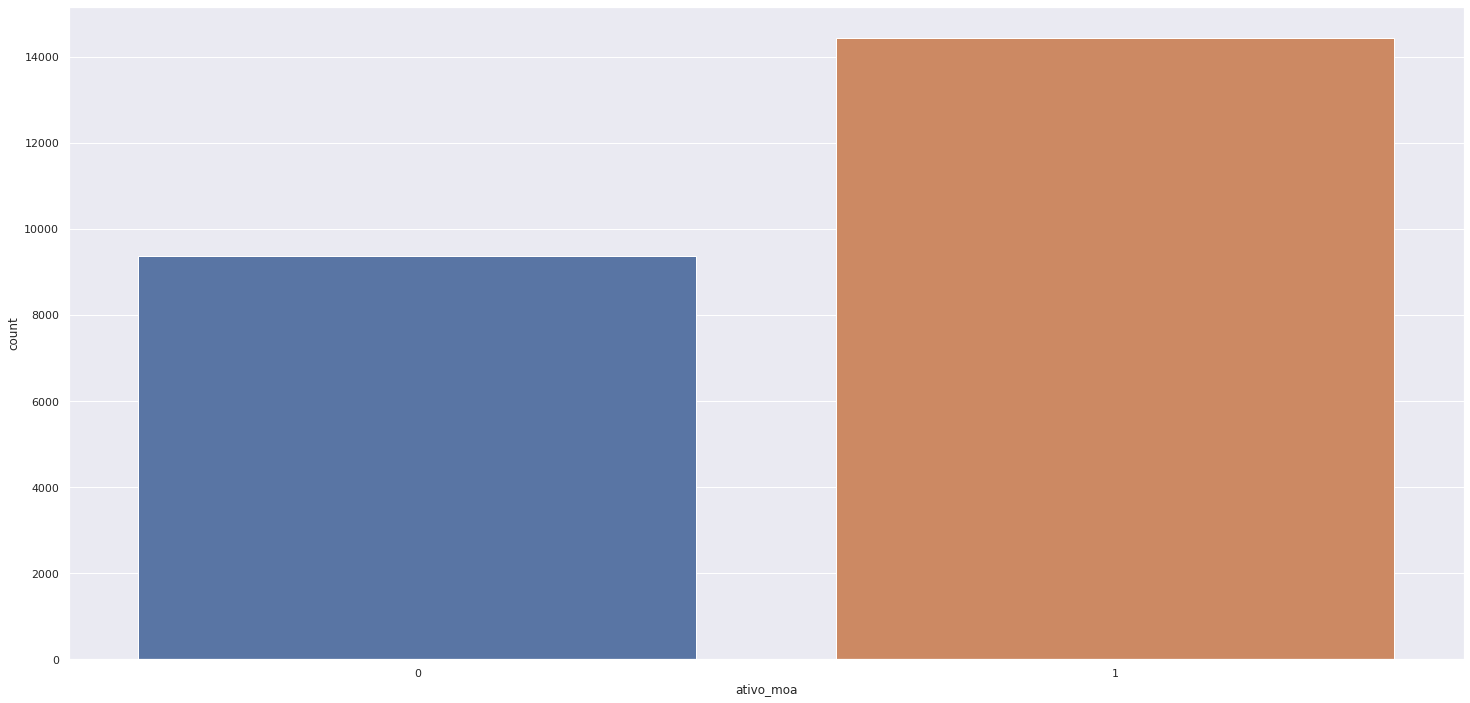

In [288]:
sns.countplot(x = df_3['ativo_moa'])

- A ocorrência modal é a de 3 ativações;
- Ativações de maior grau são menos comuns;
- Existe uma considerável quantidade de dados sem ativações;
- A variável resposta(ativação) é desbalanceada. Existem consideravelmente mais casos onde ocorrem ativações.

### 3.1.2. Variáveis Numéricas

Como os dados referentes a Viabilidade de Celular e a Expressão Genética estão presentes em grandes quantidades, serão selecionadas algumas amostras aleatórias para análise.

In [326]:
# Selecionando 10 Expressões Genéticas Aleatórias
df_g = df_3.iloc[:, 5:-97]
samples_df_g = df_g.sample(12, axis=1, random_state=25)

In [327]:
# Selecionando 10 Viabilidades Celulares Aleatórias
df_c = df_3.iloc[:, 777:-2]
samples_df_c = df_c.sample(12, axis=1, random_state=25)

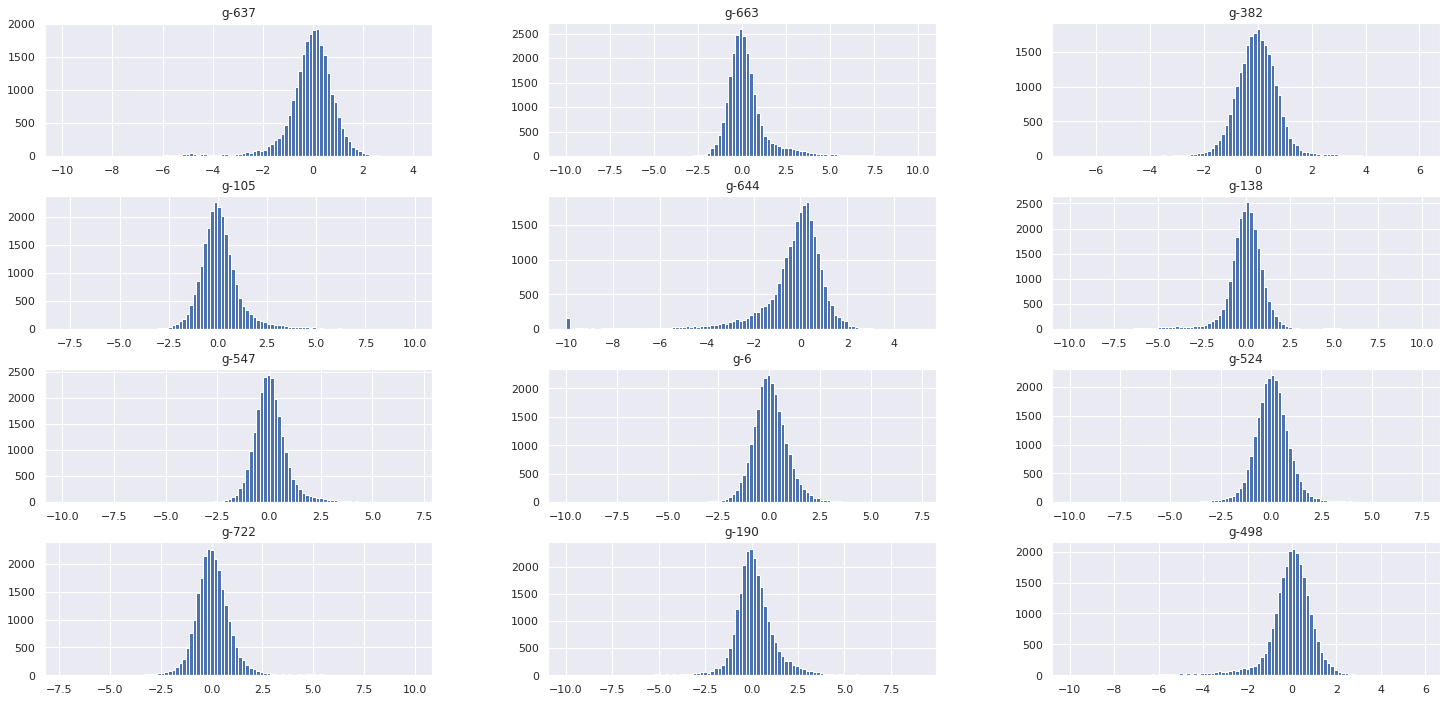

In [328]:
samples_df_g.hist(bins=100);

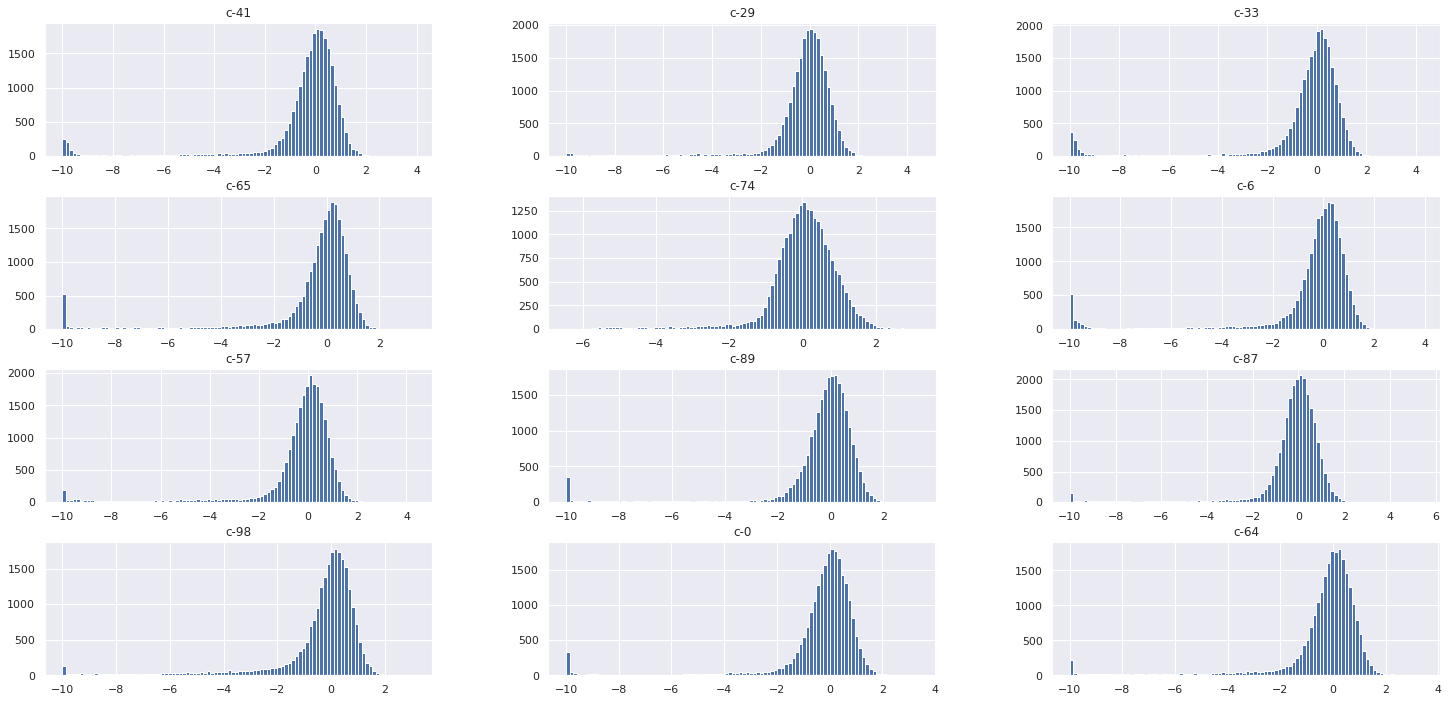

In [324]:
samples_df_c.hist(bins=100);

- Ambos os tipos de dados (g e c) estão normalizados em 0;
- Algumas samples possuem certo alongamento na calda em algum dos lados, porém reduzidas;
- Algumas samples possuem quantidades aumentados em Viabilidades Celulares mais baixas.

## 3.1.3. Variáveis Categóricas

In [330]:
cat_var = df_3.loc[:, ['tratamento', 'tempo', 'dose', 'droga']]

#### 3.1.3.1. Tratamento

In [339]:
com_droga = cat_var['tratamento'].value_counts(normalize=True)[0]
com_controle = cat_var['tratamento'].value_counts(normalize=True)[1]

<AxesSubplot:xlabel='tratamento', ylabel='count'>

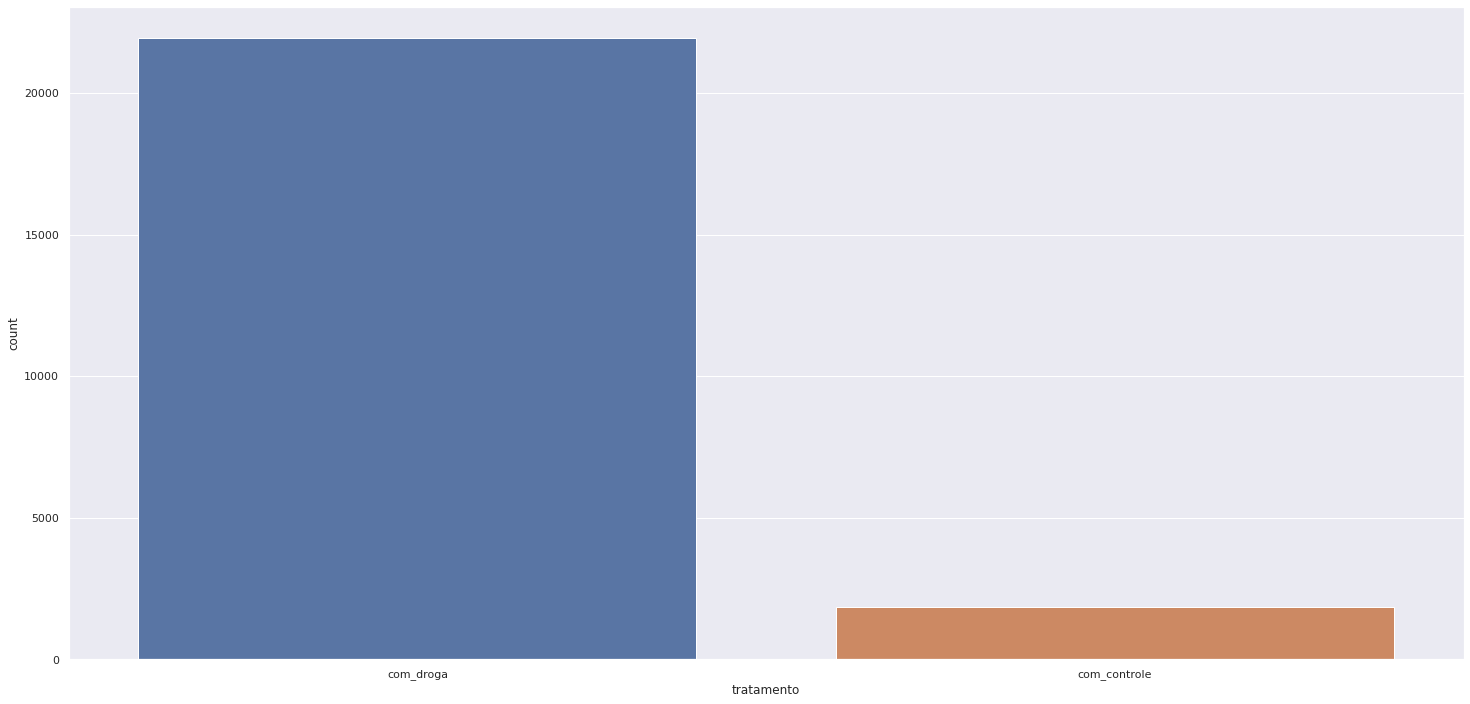

In [360]:
sns.countplot(x = cat_var['tratamento'])

In [367]:
print(f'Proporção dos dados com controle: {com_controle:.4f}')
print(f'Proporção dos dados com droga: {com_droga:.4f}')

Proporção dos dados com controle: 0.0784
Proporção dos dados com droga: 0.9216


- Tratamento é uma variável altamente desbalanceada.
- Existem muito mais casos de testes com droga do que com controle

#### 3.1.3.2 Tempo

In [359]:
t_48 = cat_var['tempo'].value_counts(normalize=True).values[0]
t_72 = cat_var['tempo'].value_counts(normalize=True).values[1]
t_24 = cat_var['tempo'].value_counts(normalize=True).values[2]

<AxesSubplot:xlabel='tempo', ylabel='count'>

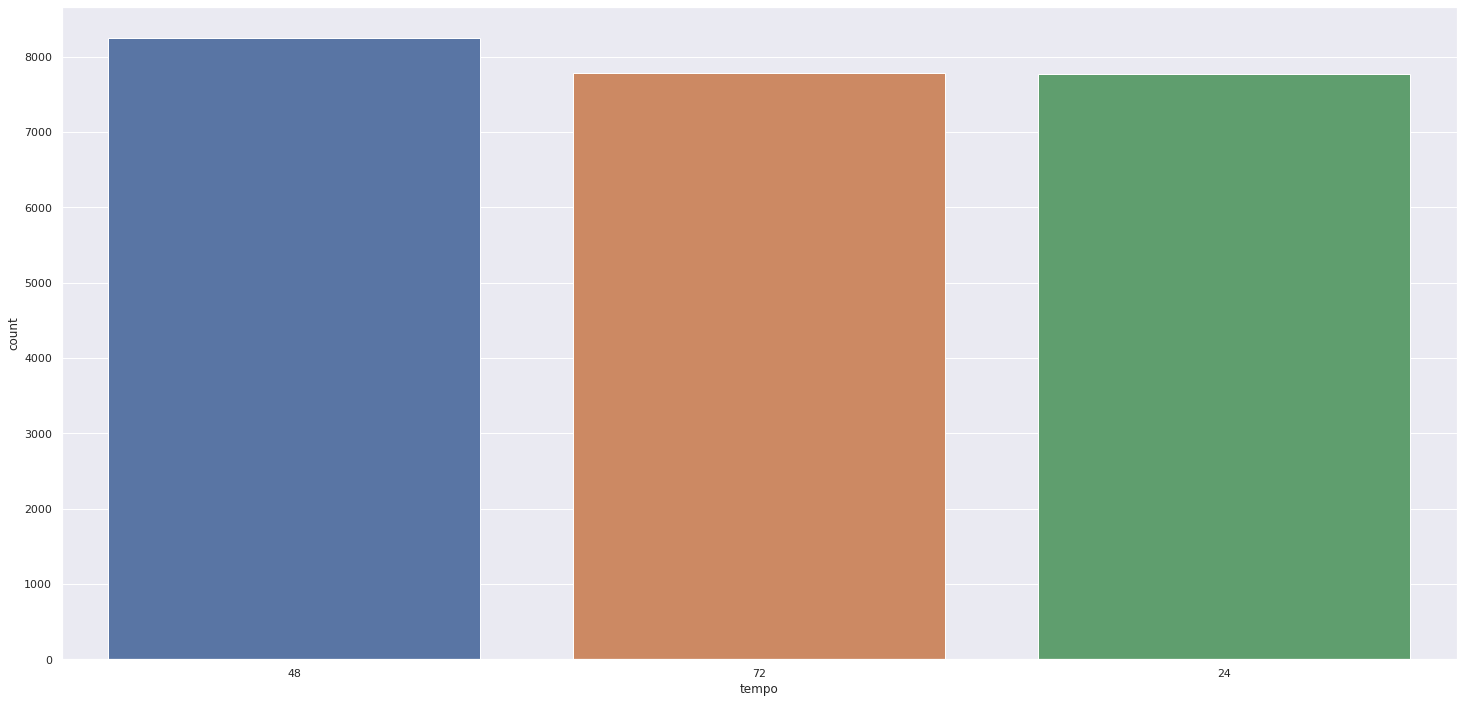

In [348]:
sns.countplot(x = cat_var['tempo'],
              order = cat_var['tempo'].value_counts().index)

In [361]:
print(f'Proporção dos dados com 24h: {t_24:.4f}')
print(f'Proporção dos dados com 48h: {t_48:.4f}')
print(f'Proporção dos dados com 72h: {t_72:.4f}')

Proporção dos dados com 24h: 0.3264
Proporção dos dados com 48h: 0.3464
Proporção dos dados com 72h: 0.3272


- A variável tempo é consideravelmente balanceada;
- O valor de maior ocorrência é de 48h

#### 3.1.2.3. Dose

In [368]:
d1 = cat_var['dose'].value_counts(normalize=True)[0]
d2 = cat_var['dose'].value_counts(normalize=True)[1]

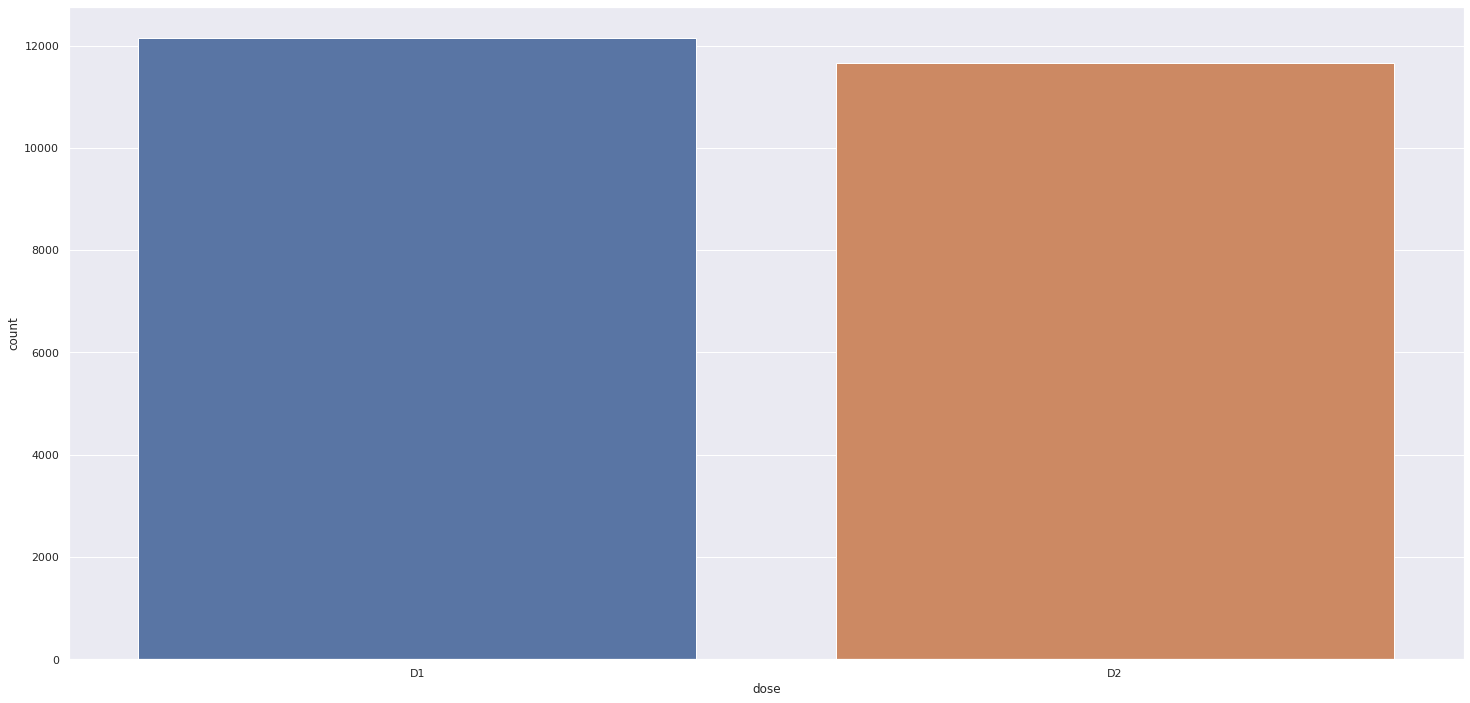

In [369]:
sns.countplot(x = cat_var['dose']);

In [370]:
print(f'Proporção dos dados D1: {d1:.4f}')
print(f'Proporção dos dados D2: {d2:.4f}')

Proporção dos dados D1: 0.5101
Proporção dos dados D2: 0.4899


- Dose é uma variável balanceada;
- D1 tem poucos casos a mais.

#### 3.1.2.4. Droga

Como existem muitas drogas, a análise será feita apenas com as que possuem mais de 100 ocorrências

In [408]:
drugs_10 = cat_var.iloc[(cat_var['droga'].value_counts() > 100), :]

ValueError: Location based indexing can only have [integer, integer slice (START point is INCLUDED, END point is EXCLUDED), listlike of integers, boolean array] types

In [393]:
df_exp[df_exp['tratamento'] == 'com_controle']['droga'].unique()

array(['cacb2b860'], dtype=object)

In [397]:
drugs_10

cacb2b860     True
87d714366     True
9f80f3f77     True
8b87a7a83     True
5628cb3ee     True
             ...  
68282e3fb    False
1d39c75d6    False
d778ccd51    False
866e7bc56    False
f19d8c43b    False
Name: droga, Length: 3289, dtype: bool

In [395]:
df_exp

,id,tratamento,tempo,dose,droga,g-0,g-1,g-2,g-3,g-4,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,com_droga,24,D1,b68db1d53,1.0620,0.5577,-0.2479,-0.6208,-0.1944,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,com_droga,72,D1,df89a8e5a,0.0743,0.4087,0.2991,0.0604,1.0190,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,com_droga,48,D1,18bb41b2c,0.6280,0.5817,1.5540,-0.0764,-0.0323,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,id_0015fd391,com_droga,48,D1,8c7f86626,-0.5138,-0.2491,-0.2656,0.5288,4.0620,...,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,id_001626bd3,com_droga,72,D2,7cbed3131,-0.3254,-0.4009,0.9700,0.6919,1.4180,...,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23809,id_fffb1ceed,com_droga,24,D2,df1d0a5a1,0.1394,-0.0636,-0.1112,-0.5080,-0.4713,...,0.1969,0.0262,-0.8121,0.3434,0.5372,-0.3246,0.0631,0.9171,0.5258,0.4680
23810,id_fffb70c0c,com_droga,24,D2,ecf3b6b74,-1.3260,0.3478,-0.3743,0.9905,-0.7178,...,0.4286,0.4426,0.0423,-0.3195,-0.8086,-0.9798,-0.2084,-0.1224,-0.2715,0.3689
23811,id_fffc1c3f4,com_controle,48,D2,cacb2b860,0.3942,0.3756,0.3109,-0.7389,0.5505,...,0.5409,0.3755,0.7343,0.2807,0.4116,0.6422,0.2256,0.7592,0.6656,0.3808
23812,id_fffcb9e7c,com_droga,24,D1,8b87a7a83,0.6660,0.2324,0.4392,0.2044,0.8531,...,-0.1105,0.4258,-0.2012,0.1506,1.5230,0.7101,0.1732,0.7015,-0.6290,0.0740
